In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
sns.set_context('paper')
sns.set_style("white")
sns.set_style('ticks')
#sns.plt.style.use(['seaborn-ticks', 'seaborn-paper'])
sns.plt.rcParams['text.usetex'] = True
sns.plt.rcParams['text.latex.preamble'] = [r'\usepackage{lmodern}']
figure_width=6
boxplot_kwargs={'fliersize':4}

In [133]:
# raw results
comparison = pd.read_pickle('../results_horseshoe_p0set_vs_unset/performance_comparison.pck')
comparison.drop(['Parametrization', 'Hyperprior', 'Type', 'Nu'], axis=1, inplace=True)
comparison['p0 set'] = ~(comparison['Model p0'] == -1)

dataset_parameters = comparison.columns[:5].tolist()
model_parameters = [comparison.columns[5], 'p0 set']

# sampler statistics
sampler_stats = pd.read_pickle('../results_horseshoe_p0set_vs_unset/sampler_statistics.pck')
sampler_stats.drop(['Parametrization', 'Hyperprior', 'Type', 'Nu'], axis=1, inplace=True)
sampler_stats['p0 set'] = ~(sampler_stats['Model p0'] == -1)

In [323]:
sampler_stats['#variables'] = sampler_stats['OTUs'] * sampler_stats['Covariates']
sampler_stats.sort_values(['#variables', 'diverging'], ascending=[True, False])

,OTUs,Covariates,Data p0,Samples,Repetition,Model p0,Dataset,Model,depth,diverging,mean_tree_accept,step_size,tree_size,p0 set,#variables
0,40,10,20,140,1,20,40O_10C_20p0_140S_1R,horseshoe_nu1_noncentered_cauchy_p020_R1,8.1150,496,0.699636,0.010899,411.4560,True,400
0,40,10,20,180,1,-1,40O_10C_20p0_180S_1R,horseshoe_nu1_noncentered_cauchy_p0-1_R1,8.4725,454,0.738930,0.009645,435.0605,False,400
0,40,10,20,180,1,20,40O_10C_20p0_180S_1R,horseshoe_nu1_noncentered_cauchy_p020_R1,8.3855,441,0.736881,0.010952,429.8825,True,400
0,40,10,20,180,2,20,40O_10C_20p0_180S_2R,horseshoe_nu1_noncentered_cauchy_p020_R2,8.5075,432,0.760891,0.010368,437.4780,True,400
0,40,10,20,60,2,20,40O_10C_20p0_60S_2R,horseshoe_nu1_noncentered_cauchy_p020_R2,7.6390,411,0.701373,0.015803,222.4955,True,400
0,40,10,20,140,1,-1,40O_10C_20p0_140S_1R,horseshoe_nu1_noncentered_cauchy_p0-1_R1,8.5485,410,0.743316,0.010992,441.3205,False,400
0,40,10,20,60,1,-1,40O_10C_20p0_60S_1R,horseshoe_nu1_noncentered_cauchy_p0-1_R1,7.6370,306,0.769840,0.015692,228.1915,False,400
0,40,10,20,220,2,-1,40O_10C_20p0_220S_2R,horseshoe_nu1_noncentered_cauchy_p0-1_R2,8.8540,303,0.778197,0.010136,471.9790,False,400
0,40,10,20,180,2,-1,40O_10C_20p0_180S_2R,horseshoe_nu1_noncentered_cauchy_p0-1_R2,8.8540,301,0.823060,0.010296,472.0835,False,400
0,40,10,20,100,2,20,40O_10C_20p0_100S_2R,horseshoe_nu1_noncentered_cauchy_p020_R2,7.8245,290,0.755263,0.013945,234.9380,True,400


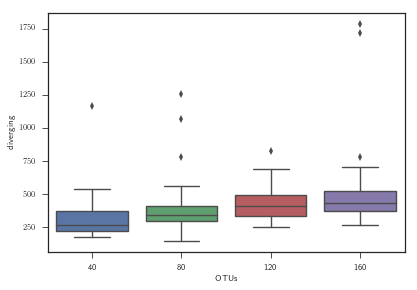

In [328]:
sampler_stats['var-sample-ratio'] = sampler_stats['#variables']/sampler_stats['Samples'].astype(float)
sampler_stats['diverging'] = sampler_stats['diverging'].astype(int)
sns.boxplot(data=sampler_stats, x='OTUs', y='diverging')

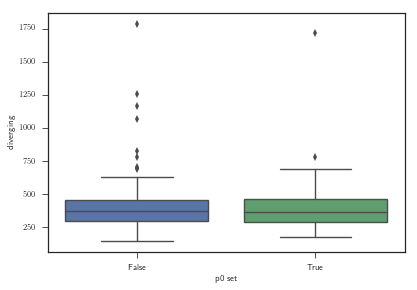

In [329]:
sns.boxplot(data=sampler_stats, x='p0 set', y='diverging')

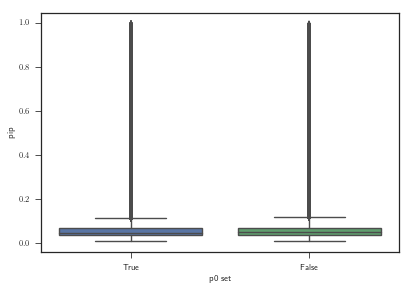

In [136]:
pip = comparison[comparison.Variable == 'pip'].copy()
pip.rename(columns={'Prediction (mean)': 'predicted', 'Prediction (std)': 'pip'}, inplace=True)
sns.boxplot(data=pip, x='p0 set', y='pip', order=[True, False])

In [137]:
print((pip.loc[pip['p0 set'], 'pip'] > 0.5).sum(), (pip.loc[~pip['p0 set'], 'pip'] > 0.5).sum())

5897 5802


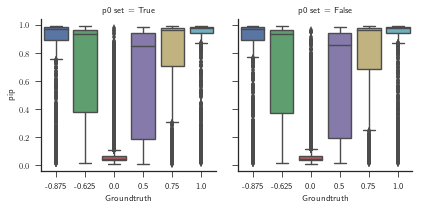

In [315]:
g = sns.FacetGrid(data=pip, col='p0 set', col_order=[True, False])
g.map(sns.boxplot, 'Groundtruth', 'pip', palette=sns.color_palette())

This is unexpected, would suggest that having a higher value for the tau0 prior leads to more variables being selected due to higher overall shrinkage
 * compare estimated values of tau
 * do scatter with aligned pip between both methods

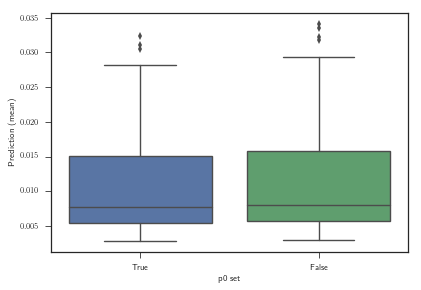

In [144]:
tau = comparison[comparison.Variable == 'tau']
sns.boxplot(data=tau, x='p0 set', y='Prediction (mean)', order=[True, False])

Interesting, the definition of p0 does not seem to have a large influence on estimated tau

In [140]:
from collections import OrderedDict
def compare_pip(data):
    p0set_sel = data['p0 set'].values
    p0set = data[p0set_sel]['pip'].values.flatten()
    gt_p0set = ~(data[p0set_sel]['Groundtruth']==0).values.flatten()
    
    p0notset = data[~p0set_sel]['pip'].values.flatten()
    gt_p0notset = ~(data[~p0set_sel]['Groundtruth']==0).values.flatten()
    assert np.all(gt_p0set == gt_p0notset)
    columns = OrderedDict()
    for col in dataset_parameters:
        columns[col] = [data[col].unique()[0]]*len(p0set)
    columns['pip p0set'] = p0set
    columns['pip p0unset'] = p0notset
    columns['Groundtruth'] = gt_p0set
    return pd.DataFrame(columns)
    
aligned_pip = pip.groupby(dataset_parameters, as_index=False).apply(compare_pip).reset_index().drop(['level_0', 'level_1'], axis=1)
aligned_pip.head()

,OTUs,Covariates,Data p0,Samples,Repetition,pip p0set,pip p0unset,Groundtruth
0,40,10,20,20,1,0.417773,0.439164,True
1,40,10,20,20,1,0.917369,0.918246,True
2,40,10,20,20,1,0.247797,0.322164,True
3,40,10,20,20,1,0.285234,0.301176,True
4,40,10,20,20,1,0.119781,0.135159,True


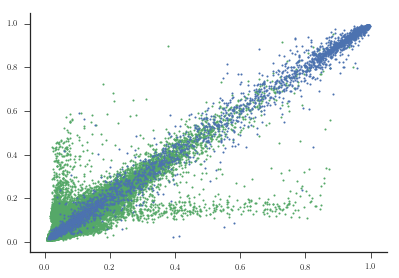

In [196]:
dataset = aligned_pip
sns.plt.scatter(dataset[dataset.Groundtruth == False]['pip p0set'], dataset[dataset.Groundtruth == False]['pip p0unset'], label='False', s=3, color=sns.color_palette()[1])
ax = sns.plt.scatter(dataset[dataset.Groundtruth == True]['pip p0set'], dataset[dataset.Groundtruth == True]['pip p0unset'], label='True', s=3, color=sns.color_palette()[0])
sns.despine()


In [ ]:
def compute_confusion_matrix(data):
    predicted = data['Prediction (mean)'].astype(bool)
    gt = data['Groundtruth'].astype(bool)
    TP = np.sum(predicted & gt)
    TN = np.sum((~predicted) & (~gt))
    FP = np.sum(predicted & (~gt))
    FN = np.sum((~predicted) & gt)
    N = TP + TN + FP + FN
    return pd.Series({'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'N':N})

include_covariate = comparison[comparison.Variable == 'include_covariate']
confusion_parameters = include_covariate.groupby(dataset_parameters+model_parameters).apply(compute_confusion_matrix).reset_index()
p = confusion_parameters
confusion_parameters['MCC'] = (p.TP*p.TN - p.FN*p.FP)/np.sqrt((p.TP + p.FP)*(p.TP + p.FN)*(p.TN + p.FP)*(p.TN + p.FN))

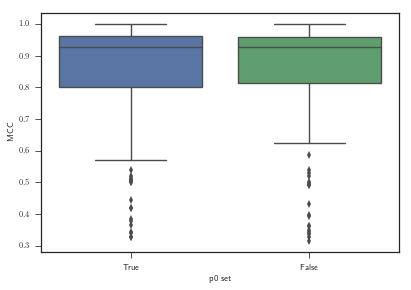

In [151]:
sns.boxplot(data=confusion_parameters, x='p0 set', y='MCC', order=[True, False])

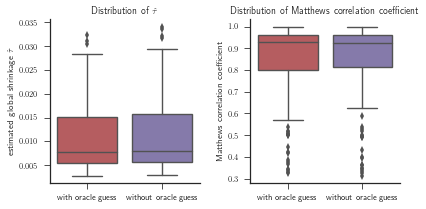

In [267]:
fig, axs = sns.plt.subplots(ncols=2, figsize=(figure_width, 3))
sns.boxplot(data=tau, x='p0 set', y='Prediction (mean)', order=[True, False], ax=axs[0], palette=sns.color_palette()[2:])
#sns.swarmplot(data=tau, x='p0 set', y='Prediction (mean)', order=[True, False], ax=axs[0], s=3, color='k')
axs[0].set_ylabel('estimated global shrinkage $\\hat{\\tau}$')
axs[0].set_xlabel('')
axs[0].set_xticklabels(['with oracle guess', 'without oracle guess'])
axs[0].set_title('Distribution of $\\hat{\\tau}$')

sns.boxplot(data=confusion_parameters, x='p0 set', y='MCC', order=[True, False], ax=axs[1], palette=sns.color_palette()[2:])
axs[1].set_title('Distribution of Matthews correlation coefficient')
axs[1].set_ylabel('Matthews correlation coefficient')
axs[1].set_xlabel('')
axs[1].set_xticklabels(['with oracle guess', 'without oracle guess'])
sns.plt.tight_layout()
sns.despine()
sns.plt.savefig('/Users/maexlich/Google Drive/Studium/Master/4. Masterthesis/3. Thesis/Figures/Results/Variable-selection/tau-mcc-distribution.pdf')

Estimates of pip differ slightly

In [148]:
def align_taus(data):
    p0set = data['p0 set'].copy()
    data = data.drop(['Variable', 'Groundtruth', 'p0 set', 'Model', 'Model p0', 'Dataset'], axis=1)
    taup0set = data[p0set].copy()
    taup0set.rename(columns={'Prediction (mean)': 'tau p0set'}, inplace=True)
    taup0set.rename(columns={'Prediction (std)': 'tau p0set (std)'}, inplace=True)
    
    taup0unset = data[~p0set].copy()
    taup0unset.rename(columns={'Prediction (mean)': 'tau p0unset'}, inplace=True)
    taup0unset.rename(columns={'Prediction (std)': 'tau p0unset (std)'}, inplace=True)
    return pd.merge(taup0set, taup0unset, on=dataset_parameters)
aligned_taus = align_taus(tau)
aligned_taus.head()

,OTUs,Covariates,Data p0,Samples,Repetition,tau p0set,Prediction (std)_x,tau p0unset,Prediction (std)_y
0,40,50,25,100,1,0.004470,0.000822,0.004728,0.000853
1,80,30,45,100,1,0.008508,0.001238,0.008929,0.001199
2,120,50,65,20,1,0.006436,0.001322,0.006873,0.001389
3,80,50,45,180,1,0.004448,0.000598,0.004602,0.000626
4,80,30,45,220,1,0.005558,0.000787,0.005808,0.000804


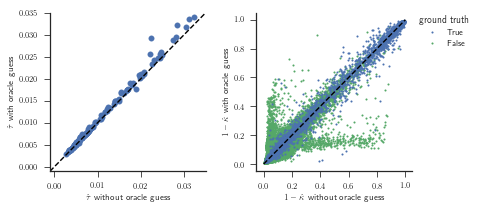

In [311]:
fig, axs = sns.plt.subplots(ncols=2, figsize=(figure_width, 3))

dmin=-0.001
dmax=0.035
axs[0].plot([dmin, dmax], [dmin, dmax], 'k--')
axs[0].scatter(aligned_taus['tau p0set'], aligned_taus['tau p0unset'])
axs[0].set_xlim((dmin, dmax))
axs[0].set_ylim((dmin, dmax))
axs[0].set_xlabel('$\\hat{\\tau}$ without oracle guess')
axs[0].set_ylabel('$\\hat{\\tau}$ with oracle guess')

axs[1].scatter(dataset[dataset.Groundtruth == False]['pip p0set'], dataset[dataset.Groundtruth == False]['pip p0unset'], label='False', s=3, color=sns.color_palette()[1])
axs[1].scatter(dataset[dataset.Groundtruth == True]['pip p0set'], dataset[dataset.Groundtruth == True]['pip p0unset'], label='True', s=3, color=sns.color_palette()[0])
axs[1].plot([0,1], [0, 1], 'k--')
axs[1].set_xlim((-0.05, 1.05))
axs[1].set_ylim((-0.05, 1.05))
axs[1].set_xlabel('$1-\\hat{\\kappa}$ without oracle guess')
axs[1].set_ylabel('$1-\\hat{\\kappa}$ with oracle guess')


handles, labels = axs[1].get_legend_handles_labels()
l = sns.plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0, title='ground truth')
sns.despine()
sns.plt.tight_layout()
sns.plt.savefig('/Users/maexlich/Google Drive/Studium/Master/4. Masterthesis/3. Thesis/Figures/Results/Variable-selection/paired-tau-pip-scatter.pdf', bbox_extra_artists=(l,), bbox_inches='tight')

$\tau$ is correctly estimated although only a very vague prior is given (Cauchy, beta=1)

### Compute MCC 

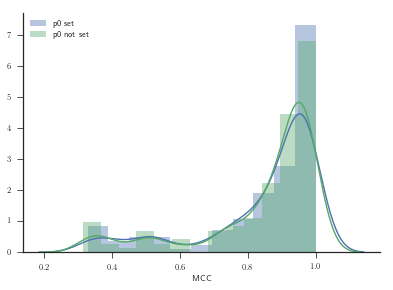

In [156]:
sns.distplot(confusion_parameters[confusion_parameters['p0 set'] == True]['MCC'], label='p0 set')
sns.distplot(confusion_parameters[confusion_parameters['p0 set'] == False]['MCC'], label='p0 not set')
sns.plt.legend()
sns.despine()

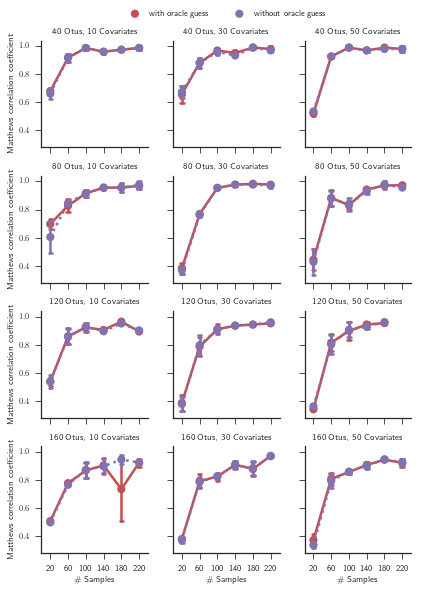

In [316]:
#confusion_parameters_rep1 = confusion_parameters[confusion_parameters.Repetition == 2]
g = sns.FacetGrid(data=confusion_parameters, col='Covariates', row='OTUs', size=2, aspect=1)
def plot_with_errorbar(samples, data, **kwargs):
    unique_samples, inverse = np.unique(samples, return_inverse=True)
    means = []
    sds = []
    for i in range(len(unique_samples)):
        sel = inverse == i
        means.append(data[sel].mean())
        sds.append(data[sel].std())
    sns.plt.errorbar(unique_samples, means, yerr=sds, **kwargs)
g.map(sns.pointplot, 'Samples', 'MCC', 'p0 set', capsize=.2, linestyles=['-', ':'], hue_order=[True, False], palette=sns.color_palette()[2:])
g.set_titles('{row_name} Otus, {col_name} Covariates')
g.set_ylabels('Matthews correlation coefficient')
g.set_xlabels('\\# Samples')
handles, labels = g.axes[0,-1].get_legend_handles_labels()
l = g.axes[0,1].legend(bbox_to_anchor=(-0.5, 1.15, 2, .102), loc=3,
           ncol=2, mode="expand", handles=handles, labels=['with oracle guess', 'without oracle guess'])

#l = sns.plt.Legend(g.axes[0,0],handles, labels, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0, ax=g.axes[0, 0])
sns.plt.savefig('/Users/maexlich/Google Drive/Studium/Master/4. Masterthesis/3. Thesis/Figures/Results/Variable-selection/screening-mcc-values.pdf', bbox_extra_artists=(l,), bbox_inches='tight')

In [284]:
confusion_parameters

,OTUs,Covariates,Data p0,Samples,Repetition,Model p0,p0 set,FN,FP,N,TN,TP,MCC
0,40,10,20,20,1,-1,False,11,1,400,379,9,0.624511
1,40,10,20,20,1,20,True,10,0,400,380,10,0.697982
2,40,10,20,20,2,-1,False,9,1,400,379,11,0.699327
3,40,10,20,20,2,20,True,10,1,400,379,10,0.662848
4,40,10,20,60,1,-1,False,2,0,400,380,18,0.946197
5,40,10,20,60,1,20,True,2,0,400,380,18,0.946197
6,40,10,20,60,2,-1,False,4,0,400,380,16,0.889757
7,40,10,20,60,2,20,True,4,0,400,380,16,0.889757
8,40,10,20,100,1,-1,False,0,0,400,380,20,1.000000
9,40,10,20,100,1,20,True,0,0,400,380,20,1.000000
